# **Population Clustering Using Principal Component Analysis**

First, let's download the data for this notebook.

In [1]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

In [2]:
from utils import download_file

if not os.path.exists(path="data"):
    os.makedirs(name="data")

download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10494344",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fpopulation_clustering%2F1000_genomes_data.txt&dl=1",
    save_filename="data/1000_genomes_data.txt",
)

Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fpopulation_clustering%2F1000_genomes_data.txt&dl=1 -> data/1000_genomes_data.txt
Total size: 20,114,920 bytes


100%|██████████| 20.1M/20.1M [00:00<00:00, 33.4MiB/s]

Download completed: data/1000_genomes_data.txt


# Data

The contents in this notebook are motivated by the article [Genes mirror geography within Europe](https://doi.org/10.1038/nature07331).

> A copy of the article is available [here](https://dataverse.harvard.edu/api/access/datafile/10494343) or [here](https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fpopulation_clustering%2Fnature07331.pdf).

In this article, the authors characterize genetic variation in a sample of 3,000 European individuals genotyped at over half a million variable DNA sites in the human genome.
They use principal components analysis (PCA) to produce a two-dimensional visual summary of the observed genetic variation.
The resulting figure bears a notable resemblance to a geographic map of Europe.
Individuals from the same geographic region cluster together and major populations are distinguishable.

<img src="images/pcs_mirror_eu_populations.png" width=600 />

In this notebook, we aim at performing a similar analysis with data from the [1000 Genomes Project](https://www.internationalgenome.org/1000-genomes-summary/).
In the file `1000_genomes_data.txt` (in the `data/` folder) we provide genetic data for 995 individuals with African ancestry.
Each of the 995 lines in the file represents an individual.

The first three columns exhibit the following semantics:

- The first column contains the individual's unique identifier.
- The second column contains the individual's sex (1=male, 2=female).
- The third column represents the population the individual belongs to. There are seven populations in the dataset: ACB, ASW, ESN, GWD, LWK, MSL, YRI.

The populations are described as follows.

> All (other) population descriptions are provided on the [_The International Genome Sample Resource_ website](https://www.internationalgenome.org/cell-lines-and-dna-coriell).

| Population code | Population description                  |
|-----------------|-----------------------------------------|
| ACB             | African Caribbean in Barbados           |
| ASW             | African Ancestry in Southwest US        |
| ESN             | Esan in Nigeria                         |
| GWD             | Gambian in Western Division, The Gambia |
| LWK             | Luhya in Webuye, Kenya                  |
| MSL             | Mende in Sierra Leone                   |
| YRI             | Yoruba in Ibadan, Nigeria               |

The remaining 10,101 columns of each line are single-nucleotide polymorphisms (SNPs) from the individual's genome.
Note: the loci of the SNPs are unknown, but they are the same across all individuals!

We can use the function [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) from [pandas](https://pandas.pydata.org) to read in the data from the file `1000_genomes_data.txt`.

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer="data/1000_genomes_data.txt", header=None, sep=r"\s+"
)
print(f"Dataframe shape: {df.shape}")

identifiers = df[0]
sexes = df[1]
populations = df[2]

print(f"Number of unique individuals: {len(np.unique(identifiers))}")
print(f"Sexes: {np.unique(sexes)}")
print(f"Populations: {np.unique(populations)}")

Dataframe shape: (995, 10104)
Number of unique individuals: 995
Sexes: [1 2]
Populations: ['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']


# Preprocessing

To understand what distinguishes individuals from different populations, we will focus on the differences between the SNP "vectors".
Hence, we first need to compute the consensus bases for all SNP loci.
Then, in a second step, we can compute for each individual the SNP aberrations w.r.t. to the consensus bases.

##### ❓ Computing the consensus bases

1. Use the [`drop()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) function to drop the first three columns (identifiers, sexes, populations) from the dataframe `df`.
2. Then, for each SNP locus, compute the respective consensus base, i.e., the base that appears most often across all individuals. The consensus bases shall be stored in a variable named `consensus_bases` of type `numpy.ndarray` with shape `(10101,)`.

In [4]:
df.drop(columns=[0, 1, 2], inplace=True)
consensus_bases = np.array(df.mode().values[0, :])  # type: ignore

##### ❓ Infer individual SNP aberrations

1. Extract a $995 \times 10101$ SNP matrix from the dataframe `df` using [to_numpy()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html).
2. Then, compute the aberrations matrix $\mathbf{X}$ such that $x_{i,j} = 0$ if the $i$-th individual's SNP at position $j$ is equal to the $j$-th consensus base, and $x_{i,j} = 1$ if the $i$-th individual's SNP at position $j$ is different from the $j$-th consensus base.

> Hint: [numpy.where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html) might be handy.

In [5]:
snps = df.to_numpy()
X = np.where(snps != consensus_bases, 1, 0)

# PCA

In the next step, our goal is to project the binary feature vectors (rows of $\mathbf{X}$) to a lower-dimensional subspace.

##### ❓ Dimensionality reduction

1. Standardize the feature vectors by removing the mean and scaling to unit variance.
2. Transform the data in $\mathbf{X}$ to a 3-dimensional subspace using [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Store the transformed data in a variable named `Z` representing the $995 \times 3$ transformed aberrations matrix $\mathbf{Z}$.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X=X)
pca = PCA(n_components=3)
Z = pca.fit_transform(X=X)

##### ❓ Population clustering

We expect that different individuals within a population have similar values of their projections onto the principal components.

Complete the following code to produce a scatter plot of all feature vectors projected onto the first and second principal components (i.e., $\mathbf{Z}$).
Use the provided colors to visualize the different population clusters.

> Notice how individuals in a particular population have similar aberrations such that their projected feature vectors start to look similar.
> Also, note that individuals in different populations have aberrations at different loci.
>
> Furthermore, note how the clusters for the two Nigerian populations (ESN, YRI) largely overlap.
> The populations from Sierra Leone (MSL) and The Gambia (GWD) are separated from the Nigerian populations through the second principal component, whereas the first principal component distinguishes the Kenyan (LWK) population from the Nigerian populations.
>
> In summary, although the principal components do not entirely correlate with well-known geographical directions (North-South, East-West) as in the European example above, they clearly convey some kind of geographic information.

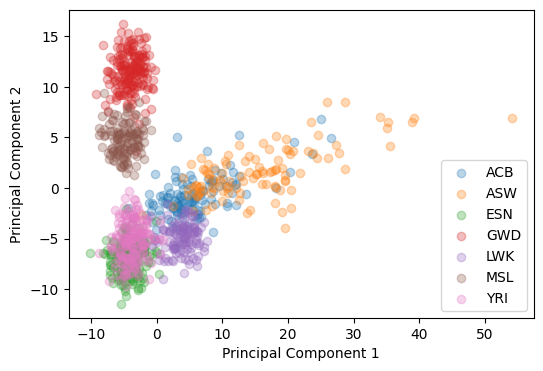

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for label, color in zip(
    np.unique(populations),
    (
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ),
):
    plt.scatter(
        Z[populations == label, 0],
        Z[populations == label, 1],
        label=label,
        c=color,
        alpha=0.3,
    )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="lower right")
plt.show()

##### ❓ Sex clustering

As seen above, different individuals within a population have similar values of their projections onto the first two principal components.
Let us now inspect the third principal component.

Complete the following code to produce a scatter plot of all feature vectors projected onto the first and _third_ principal components.
Use the provided colors to visualize the different sexes.

> Interestingly enough, the third principal component seems to encode the sex information!

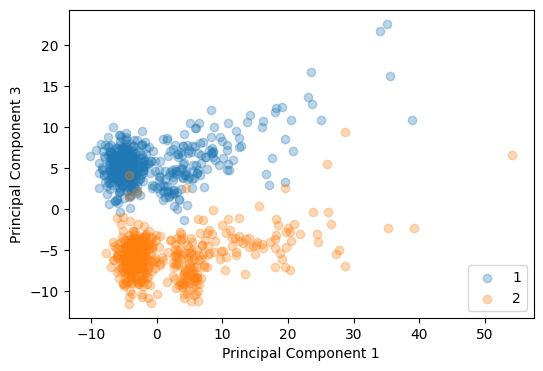

In [8]:
plt.figure(figsize=(6, 4))
for label, color in zip(np.unique(sexes), ("tab:blue", "tab:orange")):
    plt.scatter(
        Z[sexes == label, 0],
        Z[sexes == label, 2],
        label=label,
        c=color,
        alpha=0.3,
    )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 3")
plt.legend(loc="lower right")
plt.show()

##### ❓ A deeper look into the data

We just remarked above that the third principal component is responsible for popping out the sex differences.
But can we say more? Can we say which aberrations are different between males and females?

To answer this, we can look at the principal axes (i.e., eigenvectors) in the feature space, representing the directions of maximum variance in the data.

Make a scatter plot of the 10,101 values of the third principal axe (accessible as `pca.components_[2]`) versus the indexes of the aberrations (i.e., a range from 0 to 10,100).

> We can observe that the SNPs at the highest approximately 500 indexes are responsible for encoding the sex differences.
> This aligns with the fact that in most bioinformatics applications the allosomes are listed as last chromosomes in a karyogram.

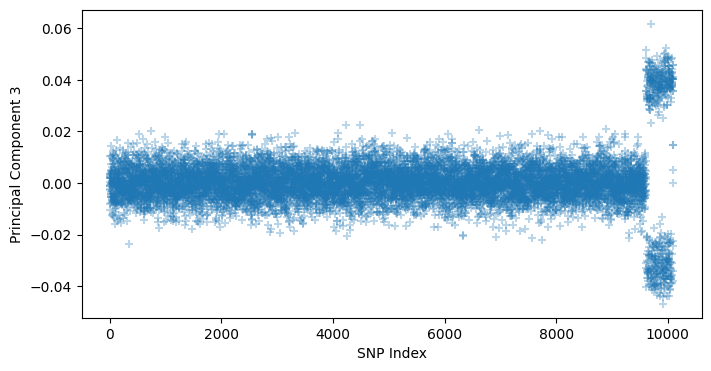

In [9]:
principal_axe_3 = pca.components_[2]
n_snp_indexes = len(principal_axe_3)

plt.figure(figsize=(8, 4))
plt.scatter(x=range(n_snp_indexes), y=principal_axe_3, alpha=0.3, marker="+")
plt.xlabel("SNP Index")
plt.ylabel("Principal Component 3")
plt.show()